In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import sys
print(sys.path)

['D:\\anaconda3\\envs\\d2l\\python39.zip', 'D:\\anaconda3\\envs\\d2l\\DLLs', 'D:\\anaconda3\\envs\\d2l\\lib', 'D:\\anaconda3\\envs\\d2l', '', 'D:\\anaconda3\\envs\\d2l\\lib\\site-packages', 'D:\\anaconda3\\envs\\d2l\\lib\\site-packages\\win32', 'D:\\anaconda3\\envs\\d2l\\lib\\site-packages\\win32\\lib', 'D:\\anaconda3\\envs\\d2l\\lib\\site-packages\\Pythonwin']


In [3]:
%matplotlib inline
import torch
from d2l import torch as d2l
import matplotlib.pyplot as plt


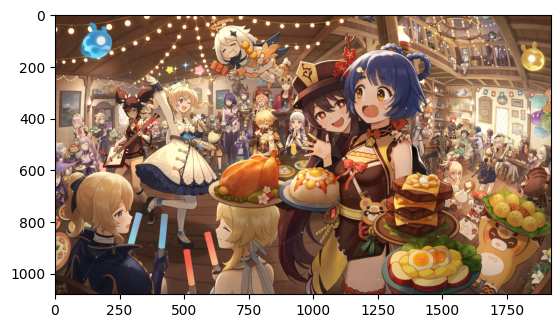

In [4]:
img = plt.imread('../data/genshin.png')
plt.imshow(img)

## 定义两种表述 之间 进行转换的函数

In [5]:
def box_corner_to_center(boxes):
    """"从 左上 右下 转换到 中间 宽度 高度"""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:,1], boxes[:,2],boxes[:,3]
    print('x1',x1.shape)
    print('x2',x2.shape)
    cx = (x1 + x2) / 2
    print('cx',cx.shape)
    cy = (y1 + y2) / 2
    w = x2 -x1
    h = y2 -y1
    boxes = torch.stack( (cx, cy, w, h), axis = -1 )
    return boxes

def box_center_to_corner(boxes):
    """从（中间，宽度，高度）转换到（左上，右下）"""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [6]:
a_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]
boxes = torch.tensor((a_bbox, cat_bbox))
boxes.shape
box_center_to_corner(box_corner_to_center(boxes)) == boxes

torch.Size([2, 4])

x1 torch.Size([2])
x2 torch.Size([2])
cx torch.Size([2])


tensor([[True, True, True, True],
        [True, True, True, True]])

In [7]:
def bbox_to_rect(bbox, color):
    return plt.Rectangle(xy=(bbox[0],bbox[1]),
                             width=bbox[2] - bbox[0],
                             height=bbox[3] - bbox[1], 
                             fill=False,
                             edgecolor=color,
                             linewidth=2)

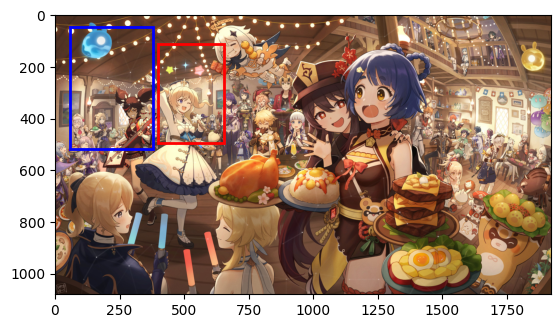

In [8]:
fig = plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(a_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'))

In [9]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

In [40]:
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签。"""
    # data_dir = d2l.download_extract('banana-detection')
    data_dir = r"D:\Dive\DiveDeepLearning\data\banana-detection"
    csv_fname = os.path.join(data_dir,
                             'bananas_train' if is_train else 'bananas_val',
                             'label.csv')
    csv_data = pd.read_csv(csv_fname)
    #
    # explain
    # 一开始索引是 0 1 2 .....
    # 现在索引是 0.png .....
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        # print(type(target))
        # print(target)
        images.append(
            torchvision.io.read_image(
                os.path.join(data_dir,
                             'bananas_train' if is_train else 'bananas_val',
                             'images', f'{img_name}')))
        targets.append(list(target))
        
    return images, torch.tensor(targets).unsqueeze(1) / 256

In [20]:
a[0].shape, b.shape

(torch.Size([3, 256, 256]), torch.Size([1, 1, 5]))

In [41]:
class BananasDataset(torch.utils.data.Dataset):
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (
            f' training examples' if is_train else f' validation examples'))
    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

In [42]:
def load_data_bananas(batch_size):
    """加载香蕉检测数据集。"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

In [44]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
#
# explain
# 获取第一个批量
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape


"""
torch.Size([32, 1, 5]))
32 批量大小
1 每个图最多多少个香蕉
5 标签 + 框的四个坐标"""

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

'\ntorch.Size([32, 1, 5]))\n32 批量大小\n1 每个图最多多少个香蕉\n5 标签 + 框的四个坐标'

In [45]:
batch[0].shape

torch.Size([32, 3, 256, 256])

In [46]:
batch[1].shape

torch.Size([32, 1, 5])

In [47]:
batch[2].shape

IndexError: list index out of range

In [35]:
type(train_iter)

torch.utils.data.dataloader.DataLoader

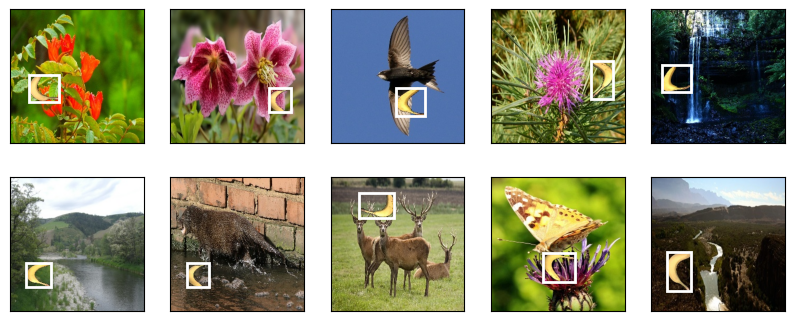

In [37]:
imgs = (batch[0][0:10].permute(0,2,3,1)) /255
axes = d2l.show_images(imgs, 2,5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])